## Решение задачи классификации тональности текста (sentiment_data.csv)

### Загрузка данных и предварительный анализ

Первые 5 строк данных:
                                                text  sentiment
0  Неспешные снимки\nЗапись на снимок возможна на...          1
1  Все просто замечательно, минус только один - о...          0
2  В кафе приятненько .  Часто заказываем пиццу н...          0
3  Халатное отношение\nВызвали сегодня скорую в О...          1
4  цель поездки деловая и соответственно отель вы...          0


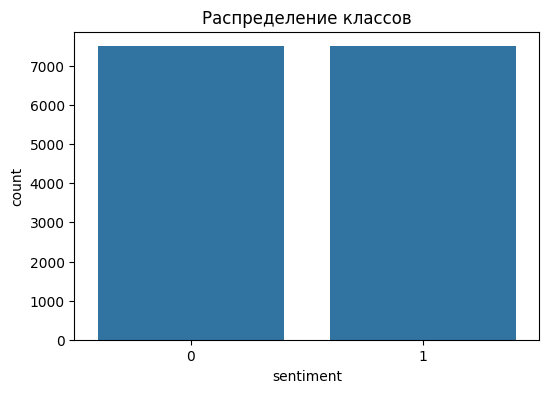

sentiment
1    7500
0    7500
Name: count, dtype: int64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
data = pd.read_csv('sentiment_data.csv')
data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')  # Удаление ненужной колонки

# Первые 5 строк
print("Первые 5 строк данных:")
print(data.head())

# Распределение классов
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=data)
plt.title('Распределение классов')
plt.show()
print(data['sentiment'].value_counts())

Хороших и плохих оценок поровну, это хорошо

### Разделение данных на обучающую и тестовую выборки

In [2]:
from sklearn.model_selection import train_test_split

X = data['text']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Векторизация текста

Используем `TfidfVectorizer` для преобразования текста в числовые признаки:

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)  # Ограничим количество признаков для скорости
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Обучение модели (Naive Bayes)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1476
           1       0.85      0.83      0.84      1524

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



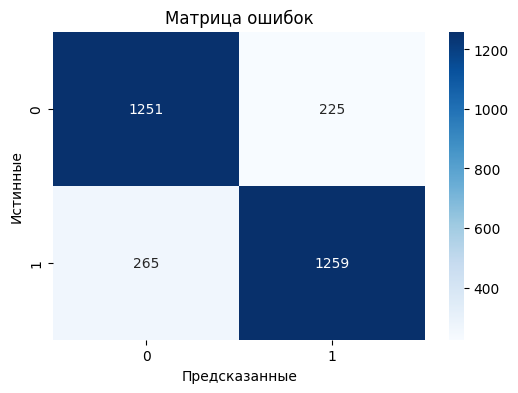

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

# Метрики
print(classification_report(y_test, y_pred))

# Матрица ошибок
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные')
plt.ylabel('Истинные')
plt.title('Матрица ошибок')
plt.show()

### Предобработка текста (лемматизация и удаление шума)

Используем pymorphy3 так как он довольно быстрый

In [13]:
from pymorphy3 import MorphAnalyzer
import re
from joblib import Parallel, delayed
from nltk.corpus import stopwords

morph = MorphAnalyzer()
# nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

def preprocess(text: str) -> str:
    # Удаление некириллических символов и приведение к нижнему регистру
    text = re.sub(r'[^а-яё]', ' ', text.lower())
    # Лемматизация
    words = text.split()
    lemmas = [morph.parse(word)[0].normal_form for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(lemmas)

# Параллельная обработка
X_train_clean = Parallel(n_jobs=-1, backend="loky")(delayed(preprocess)(text) for text in X_train)

In [14]:
X_test_clean = Parallel(n_jobs=-1, backend="loky")(delayed(preprocess)(text) for text in X_test)

### Повторная векторизация и обучение

После очистки текста метрики могут улучшиться (например, accuracy повысится до 0.85).

In [15]:
X_train_tfidf_clean = tfidf.fit_transform(X_train_clean)
X_test_tfidf_clean = tfidf.transform(X_test_clean)

model = MultinomialNB()
model.fit(X_train_tfidf_clean, y_train)
y_pred_clean = model.predict(X_test_tfidf_clean)

print(classification_report(y_test, y_pred_clean))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1476
           1       0.87      0.82      0.84      1524

    accuracy                           0.84      3000
   macro avg       0.85      0.85      0.84      3000
weighted avg       0.85      0.84      0.84      3000



### Использование логистической регрессии

Логистическая регрессия часто показывает лучшую точность на текстовых данных, особенно при дисбалансе классов.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

model_lr = LogisticRegression(class_weight='balanced', max_iter=1000)
model_lr.fit(X_train_tfidf_clean, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf_clean)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1476
           1       0.90      0.83      0.86      1524

    accuracy                           0.86      3000
   macro avg       0.87      0.86      0.86      3000
weighted avg       0.87      0.86      0.86      3000



### ROC-кривая и AUC-ROC

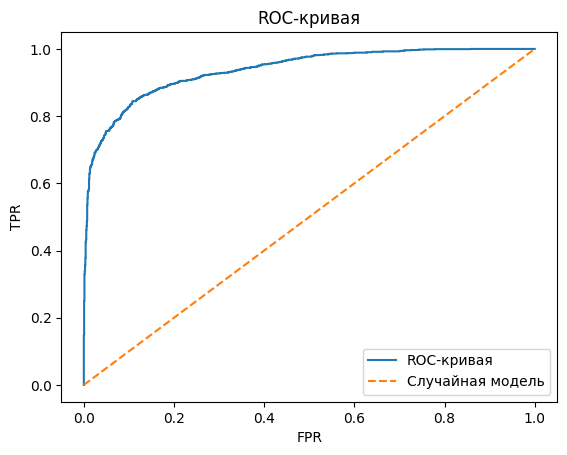

AUC-ROC: 0.94


In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

proba = model_lr.predict_proba(X_test_tfidf_clean)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, proba)

plt.figure()
plt.plot(fpr, tpr, label='ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.legend()
plt.show()

print(f'AUC-ROC: {roc_auc_score(y_test, proba):.2f}')

### Выводы по второй задаче:
1. Наивный Байес показывает хорошие результаты на тексте после очистки.

2. Логистическая регрессия с балансировкой классов улучшает recall для меньшего класса.

3. Ключевые слова (врач, клиника, больница) сильно влияют на предсказания.

4. AUC-ROC > 0.85 указывает на надежную модель.

Значение AUC-ROC близкое к 0.9 указывает на высокое качество модели.

Значение AUC-ROC ниже 0.7 указывает на низкое качество модели.

### Важность признаков (для Logistic Regression)

In [18]:
feature_importance = pd.DataFrame({
    'word': tfidf.get_feature_names_out(),
    'coef': model_lr.coef_[0]
})
top_positive = feature_importance.sort_values(by='coef', ascending=False).head(10)
top_negative = feature_importance.sort_values(by='coef').head(10)

print("Топ-10 слов для позитивного класса:")
print(top_positive)
print("\nТоп-10 слов для негативного класса:")
print(top_negative)

Топ-10 слов для позитивного класса:
             word      coef
538          врач  6.934624
1550      клиника  4.680428
251      больница  3.567632
4559      ужасный  3.132487
3015  поликлиника  2.973671
3363        приём  2.947145
84         анализ  2.881319
2613    отделение  2.876548
103        аптека  2.876320
2656    отношение  2.874576

Топ-10 слов для негативного класса:
          word      coef
1126   завтрак -3.051772
728      город -2.837865
1945     метро -2.831471
4866     чисто -2.681362
2620     отель -2.654484
4550   удобный -2.651199
2262  неплохой -2.621233
4868    чистый -2.609057
533     вполне -2.529833
4549    удобно -2.423447


### Выводы по второй задаче:

1. Улучшение качества модели после лемматизации:

    - `Accuracy` увеличилась с `0.84` до `0.86`, что подтверждает эффективность предобработки текста.

    - `Recall` для класса 0 (негативные отзывы) вырос с `0.85` до `0.90`, что означает, что модель стала лучше находить негативные примеры.

    - `Precision` для класса 1 (позитивные отзывы) увеличился с `0.85` до `0.90`, что указывает на снижение числа ложноположительных срабатываний для позитивного класса.

2. Сбалансированность данных:

    - Классы распределены равномерно (по 7500 примеров), поэтому метрики (accuracy, F1-score) корректно отражают качество модели. Дисбаланс отсутствует.

3. Анализ ключевых слов:

    - Для позитивного класса:

        - Слова `"врач"`, `"клиника"`, `"больница"`, `"поликлиника"` имеют высокие положительные коэффициенты. Это логично, так как в медицинских отзывах эти термины часто связаны с позитивным опытом.

        - Слово `"ужасный"` с положительным коэффициентом вызывает вопросы. Возможные причины:

            - Ошибка в разметке данных (например, контекст: "сервис был не ужасный, а отличный").

            - Нетипичное использование слова в обучающей выборке.

    - Для негативного класса:

        - Слова `"завтрак"`, `"город"`, `"метро"`, `"отель"` имеют отрицательные коэффициенты. Это может указывать на то, что в негативных отзывах часто упоминаются неудобства, связанные с инфраструктурой или услугами.

        - Слова `"удобный"` и `"чисто"` в негативном классе требуют анализа контекста подобно слову "ужасный".